### Questions vs Statements Classification

## Source of data set

https://huggingface.co/datasets/jonaskoenig/Questions-vs-Statements-Classification



This project’s objective is to categorize sentences as follows:  

Statement (Declarative Sentence)  

Question (Interrogative Sentence)  

This dataset is constructed by extracting the SQuAD dataset and integrating it with SPAADIA.  

The samples in the dataset:  
Statement 80167  
Question 131001  

Note: For the purpose of this dataset, questions are one complete sentence. Statements can be longer than one sentence but are concise and self-sufficient on their own.



In [ ]:
!pip install imbalanced-learn

## Importing all necessary libraries

In [ ]:
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Loading Dataset

In [ ]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/jonaskoenig/Questions-vs-Statements-Classification/" + splits["train"])
df_test = pd.read_csv("hf://datasets/jonaskoenig/Questions-vs-Statements-Classification/" + splits["test"])
df_train.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,labels
0,"For the rest of February, the Americans pushe...",0
1,During the second half of the 19th century Dut...,1
2,When did Egyptians start to make red pigment?,1
3,"In a 2012 report, the National Center for Sta...",0
4,What is an acceptable grounds for divorce for ...,1


In [ ]:
print(df_train.shape)

print(df_test.shape)


(126909, 2)
(42303, 2)


# Checking the balance of the data

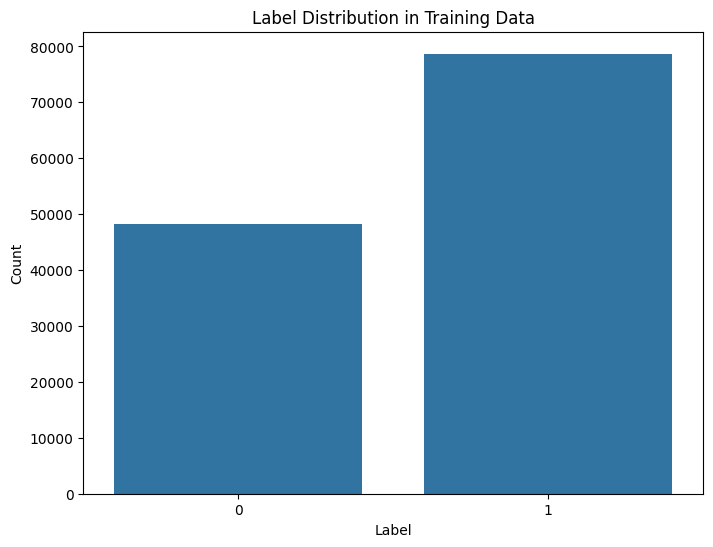

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=df_train)
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


--- B. Distribution of Message Lengths ---


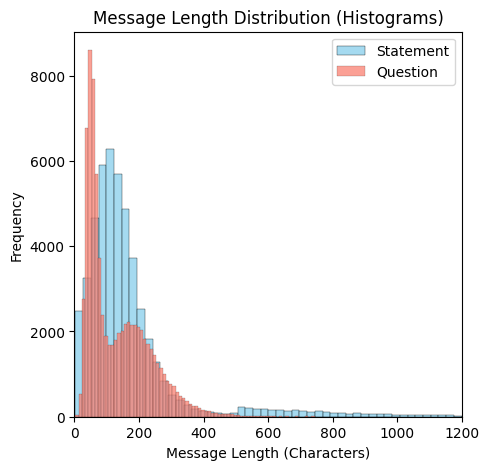

In [ ]:
print("\n--- B. Distribution of Message Lengths ---")
df_train['text_length'] = df_train['text'].apply(len)

plt.figure(figsize=(5, 5))

sns.histplot(df_train[df_train['labels'] == 0]['text_length'], bins=100, color='skyblue', label='Statement')
sns.histplot(df_train[df_train['labels'] == 1]['text_length'], bins=100, color='salmon', label='Question')
plt.title('Message Length Distribution (Histograms)')
plt.xlabel('Message Length (Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 1200)
plt.show()



## WordCloud

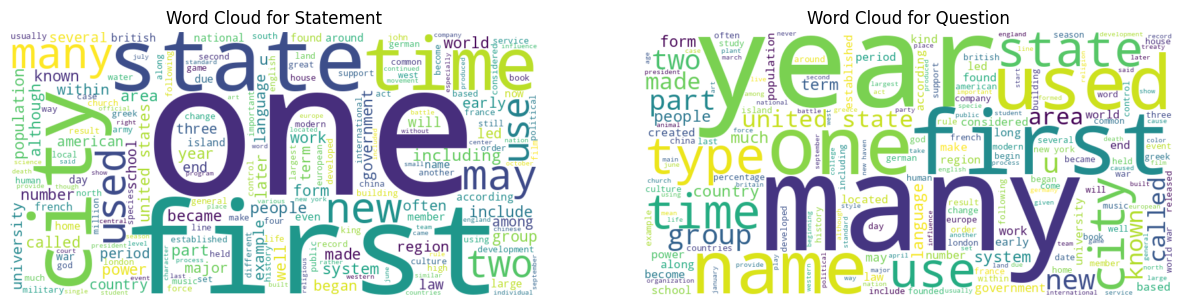

In [ ]:
def clean_for_wordcloud(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

Statement = ' '.join(df_train[df_train['labels'] == 0]['text'].apply(clean_for_wordcloud))
Question = ' '.join(df_train[df_train['labels'] == 1]['text'].apply(clean_for_wordcloud))

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
wordcloud_Statement = WordCloud(width=800, height=400, background_color='white').generate(Statement)
plt.imshow(wordcloud_Statement, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Statement')

plt.subplot(1, 2, 2)
wordcloud_Question = WordCloud(width=800, height=400, background_color='white').generate(Question)
plt.imshow(wordcloud_Question, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question')

plt.show()

## Text Cleaning

In [ ]:
print("\n--- 2. Text Cleaning (for traditional models) ---")

stop_words = set(stopwords.words('english'))

def clean_text_traditional(text):

    text = text.lower()

    text = re.sub(r'http\S+|www\S+|\S+\.com\S+', ' ', text)

    text = ''.join([char for char in text if char not in string.punctuation])

    text = re.sub(r'\d+', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("\nApplying cleaning to the entire dataset for traditional models...")
df_train['cleaned_text'] = df_train['text'].apply(clean_text_traditional)

df_test['cleaned_text'] = df_test['text'].apply(clean_text_traditional)
print("Cleaning complete. Displaying first 5 cleaned messages:")
print(df_train[['text', 'cleaned_text']].head())



--- 2. Text Cleaning (for traditional models) ---

Applying cleaning to the entire dataset for traditional models...
Cleaning complete. Displaying first 5 cleaned messages:
                                                text  \
0   For the rest of February, the Americans pushe...   
1  During the second half of the 19th century Dut...   
2      When did Egyptians start to make red pigment?   
3   In a 2012 report, the National Center for Sta...   
4  What is an acceptable grounds for divorce for ...   

                                        cleaned_text  
0  for the rest of february the americans pushed ...  
1  during the second half of the th century dutch...  
2       when did egyptians start to make red pigment  
3  in a report the national center for state cour...  
4  what is an acceptable grounds for divorce for ...  


## Pre Processing

In [ ]:
print("\n--- 3. Pre-processing (for traditional models: Tokenization & Lemmatization) ---")

lemmatizer = WordNetLemmatizer()

def preprocess_text_traditional(text):

    tokens = nltk.word_tokenize(text)

    filtered_tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return lemmatized_tokens

print("\nApplying pre-processing to the entire dataset for traditional models...")

df_train['preprocessed_tokens'] = df_train['cleaned_text'].apply(preprocess_text_traditional)

df_test['preprocessed_tokens'] = df_test['cleaned_text'].apply(preprocess_text_traditional)

df_train['preprocessed_string'] = df_train['preprocessed_tokens'].apply(lambda x: ' '.join(x))

df_test['preprocessed_string'] = df_test['preprocessed_tokens'].apply(lambda x: ' '.join(x))

print("Pre-processing complete. Displaying first 5 preprocessed token lists and strings:")
print(df_train[['text', 'preprocessed_tokens', 'preprocessed_string']].head())



--- 3. Pre-processing (for traditional models: Tokenization & Lemmatization) ---

Applying pre-processing to the entire dataset for traditional models...
Pre-processing complete. Displaying first 5 preprocessed token lists and strings:
                                                text  \
0   For the rest of February, the Americans pushe...   
1  During the second half of the 19th century Dut...   
2      When did Egyptians start to make red pigment?   
3   In a 2012 report, the National Center for Sta...   
4  What is an acceptable grounds for divorce for ...   

                                 preprocessed_tokens  \
0  [rest, february, american, pushed, north, marc...   
1  [second, half, th, century, dutch, banned, lev...   
2              [egyptian, start, make, red, pigment]   
3  [report, national, center, state, court, court...   
4    [acceptable, ground, divorce, jehovah, witness]   

                                 preprocessed_string  
0  rest february american pushed n

In [ ]:
x_train = df_train['preprocessed_string']
y_train = df_train['labels']

x_test = df_test['preprocessed_string']
y_test = df_test['labels']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [ ]:
print("Shape of x_train_tfidf before SMOTE:", x_train_tfidf.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Distribution of y_train before SMOTE:\n", y_train.value_counts())

smote = SMOTE(random_state=42)

x_train_resampled, y_train_resampled = smote.fit_resample(x_train_tfidf, y_train)

print("\nShape of x_train_resampled after SMOTE:", x_train_resampled.shape)
print("Shape of y_train_resampled after SMOTE:", y_train_resampled.shape)
print("Distribution of y_train_resampled after SMOTE:\n", y_train_resampled.value_counts())

Shape of x_train_tfidf before SMOTE: (126909, 20000)
Shape of y_train before SMOTE: (126909,)
Distribution of y_train before SMOTE:
 labels
1    78701
0    48208
Name: count, dtype: int64

Shape of x_train_resampled after SMOTE: (157402, 20000)
Shape of y_train_resampled after SMOTE: (157402,)
Distribution of y_train_resampled after SMOTE:
 labels
0    78701
1    78701
Name: count, dtype: int64


# Random search for KNN, Decision tree, Logistic regression

In [ ]:
param_distributions_knn = {
    'n_neighbors': randint(3, 10),
    'weights': ['uniform', 'distance']
}

param_distributions_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(10, 30),
    'min_samples_leaf': randint(1, 10),
    'splitter': ['best', 'random'],
    'min_impurity_decrease': uniform(0, 0.1),
    'min_weight_fraction_leaf': uniform(0, 0.2),
    'max_features': [None, 'sqrt', 'log2'],
}

param_distributions_logreg = {
    'C': uniform(0.01, 100),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': randint(100, 500),
    'class_weight': [None, 'balanced']
}

In [ ]:
models_random_search = {
    "KNN": (KNeighborsClassifier(), param_distributions_knn),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), param_distributions_dt),
    "Logistic Regression": (LogisticRegression(random_state=42), param_distributions_logreg)
}

In [ ]:
best_models = {}

for name, (model, param_distributions) in models_random_search.items():

    random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(x_train_tfidf, y_train)
    best_models[name] = random_search.best_estimator_


print(best_models)

{'KNN': KNeighborsClassifier(weights='distance'), 'Decision Tree': DecisionTreeClassifier(max_depth=29,
                       min_impurity_decrease=np.float64(0.01834347898661638),
                       min_samples_leaf=8,
                       min_weight_fraction_leaf=np.float64(0.11973169683940732),
                       random_state=42), 'Logistic Regression': LogisticRegression(C=np.float64(4.676566321361543), class_weight='balanced',
                   max_iter=370, random_state=42, solver='saga')}


## Classification Report


--- Evaluating Best Models on Test Set ---

Evaluating KNN...
Accuracy: 0.5899

Confusion Matrix:
[[12280  3825]
 [13523 12675]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.76      0.59     16105
           1       0.77      0.48      0.59     26198

    accuracy                           0.59     42303
   macro avg       0.62      0.62      0.59     42303
weighted avg       0.66      0.59      0.59     42303



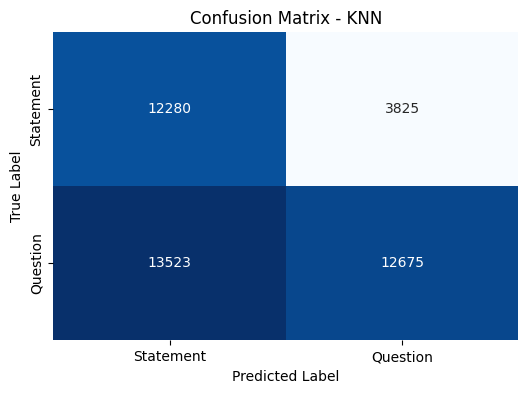


Evaluating Decision Tree...
Accuracy: 0.6193

Confusion Matrix:
[[    0 16105]
 [    0 26198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16105
           1       0.62      1.00      0.76     26198

    accuracy                           0.62     42303
   macro avg       0.31      0.50      0.38     42303
weighted avg       0.38      0.62      0.47     42303



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


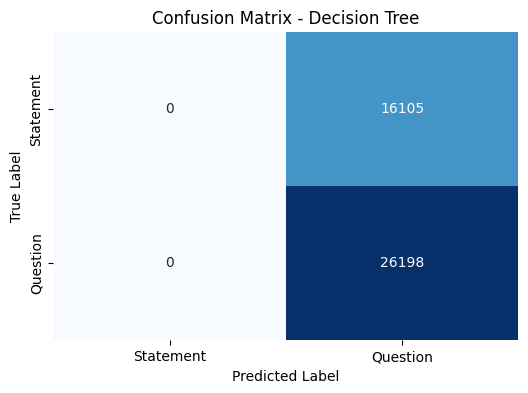


Evaluating Logistic Regression...
Accuracy: 0.6931

Confusion Matrix:
[[10665  5440]
 [ 7541 18657]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62     16105
           1       0.77      0.71      0.74     26198

    accuracy                           0.69     42303
   macro avg       0.68      0.69      0.68     42303
weighted avg       0.70      0.69      0.70     42303



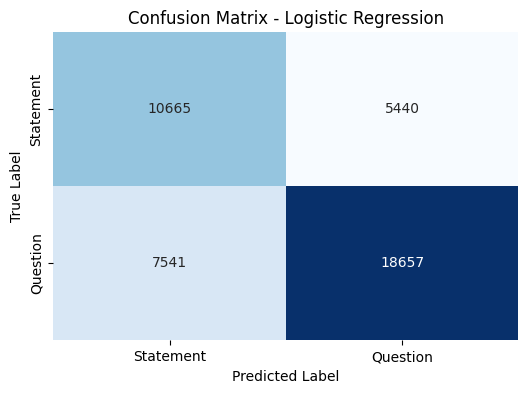


--- Summary of Test Set Results ---

KNN:
  Accuracy: 0.5899
  Confusion Matrix:
 [[12280  3825]
 [13523 12675]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.76      0.59     16105
           1       0.77      0.48      0.59     26198

    accuracy                           0.59     42303
   macro avg       0.62      0.62      0.59     42303
weighted avg       0.66      0.59      0.59     42303


Decision Tree:
  Accuracy: 0.6193
  Confusion Matrix:
 [[    0 16105]
 [    0 26198]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     16105
           1       0.62      1.00      0.76     26198

    accuracy                           0.62     42303
   macro avg       0.31      0.50      0.38     42303
weighted avg       0.38      0.62      0.47     42303


Logistic Regression:
  Accuracy: 0.6931
  Confusion Matrix:
 [[10665  5440]
 [ 7541 18657]]


In [ ]:
print("\n--- Evaluating Best Models on Test Set ---")

results = {}

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(x_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Statement', 'Question'], yticklabels=['Statement', 'Question'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\n--- Summary of Test Set Results ---")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print("  Confusion Matrix:\n", metrics['confusion_matrix'])
    print("  Classification Report:\n", metrics['classification_report'])